In [85]:
!pip install catboost

In [86]:
!pip install lightgbm

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew 


from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [88]:
dataset = load_boston()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [89]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Смотрим распределение целевой переменной

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


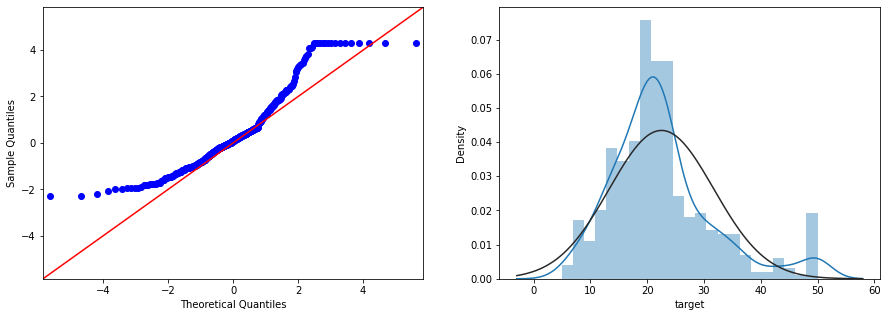

In [90]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
sm.qqplot(df.target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(df.target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

## Используем scew для приведения к нормальному распределению

In [91]:
num_features = df.select_dtypes(exclude=['object']).columns 

skewness = df[num_features].apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

skewness = skewness[abs(skewness)>0.5]

skew_features = df[skewness.index]

In [92]:
df[skew_features.columns] = np.log1p(df[skew_features.columns])
df[skew_features.columns]

,CRIM,ZN,CHAS,NOX,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.006300,2.944439,0.0,0.430483,4.192680,1.627278,0.693147,5.693732,2.791165,5.986201,1.788421,3.218876
1,0.026944,0.000000,0.0,0.384582,4.380776,1.786261,1.098612,5.493061,2.933857,5.986201,2.316488,3.117950
2,0.026924,0.000000,0.0,0.384582,4.128746,1.786261,1.098612,5.493061,2.933857,5.975919,1.615420,3.575151
3,0.031857,0.000000,0.0,0.377066,3.845883,1.954757,1.386294,5.407172,2.980619,5.980479,1.371181,3.538057
4,0.066770,0.000000,0.0,0.377066,4.010963,1.954757,1.386294,5.407172,2.980619,5.986201,1.845300,3.616309
...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.060747,0.000000,0.0,0.452985,4.249923,1.246630,0.693147,5.613128,3.091042,5.973784,2.367436,3.152736
502,0.044275,0.000000,0.0,0.452985,4.352855,1.190127,0.693147,5.613128,3.091042,5.986201,2.310553,3.072693
503,0.058986,0.000000,0.0,0.452985,4.521789,1.152943,0.693147,5.613128,3.091042,5.986201,1.893112,3.214868
504,0.103991,0.000000,0.0,0.452985,4.503137,1.220505,0.693147,5.613128,3.091042,5.977492,2.012233,3.135494


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


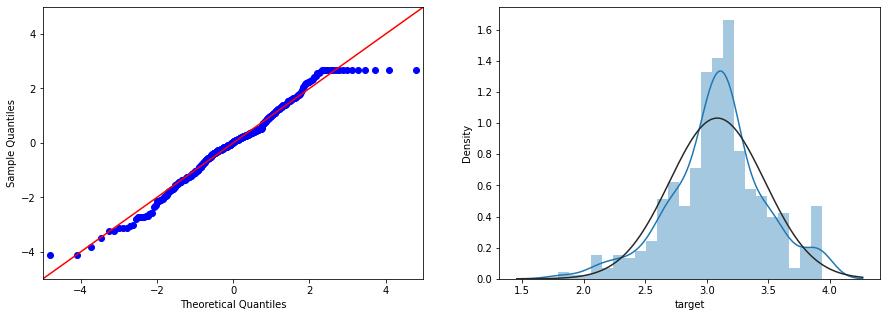

In [93]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
sm.qqplot(df.target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(df.target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

## Сплитим

In [94]:
y = df['target']

In [95]:
train = df.drop('target',axis = 1)

In [96]:
y.head()

0    3.218876
1    3.117950
2    3.575151
3    3.538057
4    3.616309
Name: target, dtype: float64

In [97]:
x_train,x_test,y_train,y_test = train_test_split(train,y.to_numpy(),random_state= 42)

## Обучаем модель

In [98]:
gbr = GradientBoostingRegressor(max_depth=2, learning_rate = 0.1, n_estimators=200)
gbr.fit(x_train, y_train)

train_pre = gbr.predict(x_train)
test_pre = gbr.predict(x_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.005147814885658622
test MSE: 0.028693926488619372


In [99]:
cat = CatBoostRegressor(depth=2, learning_rate = .1, iterations=200, silent = True)
cat.fit(x_train, y_train)

train_pre = cat.predict(x_train)
test_pre = cat.predict(x_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.010775584685191214
test MSE: 0.025364715019190156


In [100]:
lightgbm = LGBMRegressor(objective='regression',num_leaves=4, learning_rate=0.01, 
                         n_estimators=5000,max_bin=200, bagging_fraction=0.75,
                         bagging_freq=5, bagging_seed=7,feature_fraction=0.2,
                         feature_fraction_seed=7, verbose=-1)
lightgbm.fit(x_train,y_train)

train_pre = lightgbm.predict(x_train)
test_pre = lightgbm.predict(x_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))


train MSE: 0.006682882994667054
test MSE: 0.020094217673208653
